## Chapter Two

In [1]:
from fastbook import *
from fastai.vision.widgets import *

### Creating Image Search with Bing API

In [2]:
key = os.environ.get('AZURE_SEARCH_KEY', '')

In [3]:
results = search_images_bing(key, 'van gogh paintings')
images = results.attrgot('content_url')
len(images)

150

In [4]:
# inspect an image
destination = 'images/van_gogh.jpg'
download_url(images[0], destination)

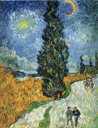

In [5]:
# open image
image = Image.open(destination)
image.to_thumb(128, 128)

In [4]:
# select some great painters
great_painters = ['vincent van gogh', 'pablo picasso', 'michelangelo', 'leonardo da vinci', 'william turner',
                  'leonardo da vinci', 'diego rodriguez de silva y velazquez', 'rembrandt van rijn', 'edvard munch', 
                  'frida kahlo', 'jackson pollock', 'jan vermeer', 'salvador dali', 'auguste renoir', 'edward hopper']

In [18]:
path = Path('../storage/painters')
path

Path('../storage/painters')

In [19]:
if not path.exists():
    path.mkdir()

In [ ]:
# download and save images of painters
for painter in great_painters:
    dest = (path/painter.replace(' ', '_'))
    dest.mkdir(exist_ok=True)
    results = search_images_bing(key, f"{painter} paintings")
    download_images(dest, urls=results.attrgot('content_url'))

In [21]:
# inspect files
files = get_image_files(path)
files

(#2081) [Path('../storage/painters/edward_hopper/00000036.jpg'),Path('../storage/painters/edward_hopper/00000113.jpg'),Path('../storage/painters/edward_hopper/00000088.jpg'),Path('../storage/painters/edward_hopper/00000062.jpg'),Path('../storage/painters/edward_hopper/00000100.jpg'),Path('../storage/painters/edward_hopper/00000033.jpg'),Path('../storage/painters/edward_hopper/00000134.jpg'),Path('../storage/painters/edward_hopper/00000015.jpg'),Path('../storage/painters/edward_hopper/00000121.jpg'),Path('../storage/painters/edward_hopper/00000071.jpg')...]

In [22]:
# do we have failed images?
failed_images = verify_images(files)
failed_images

(#17) [Path('../storage/painters/edward_hopper/00000090.jpg'),Path('../storage/painters/pablo_picasso/00000015.jpg'),Path('../storage/painters/pablo_picasso/00000135.jpg'),Path('../storage/painters/pablo_picasso/00000083.jpg'),Path('../storage/painters/pablo_picasso/00000038.jpg'),Path('../storage/painters/leonardo_da_vinci/00000040.jpg'),Path('../storage/painters/leonardo_da_vinci/00000055.jpg'),Path('../storage/painters/jan_vermeer/00000119.jpg'),Path('../storage/painters/jan_vermeer/00000117.jpg'),Path('../storage/painters/frida_kahlo/00000121.jpg')...]

In [23]:
??verify_images

In [24]:
# lets delete the failed ones
failed_images.map(Path.unlink)

(#17) [None,None,None,None,None,None,None,None,None,None...]

### Build a DataLoader

In [25]:
# create a loader with fastai framework
paintings_block = DataBlock(
    blocks=(ImageBlock, CategoryBlock),
    get_items=get_image_files,
    splitter=RandomSplitter(valid_pct=.2, seed=42),
    get_y=parent_label,
    item_tfms=Resize(128)
)

In [26]:
# tell fastai where the loader must operate
loader = paintings_block.dataloaders(path)

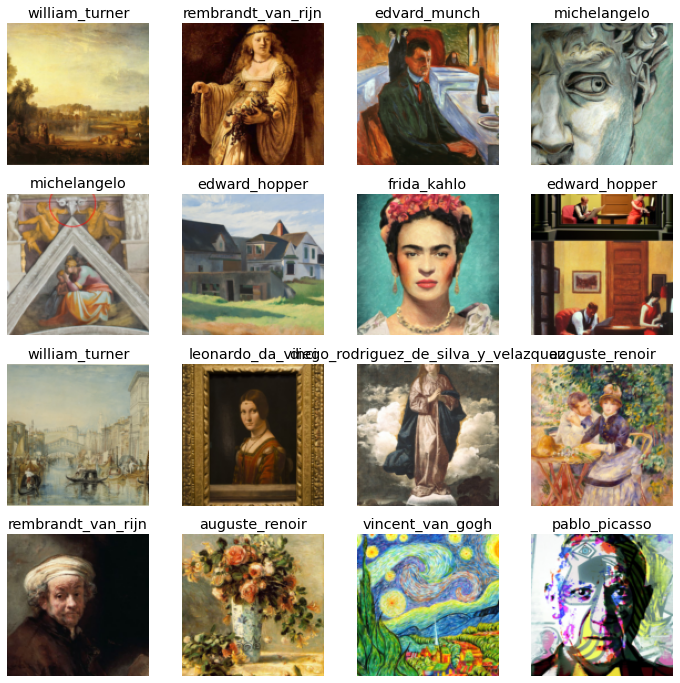

In [27]:
# show some examples
loader.valid.show_batch(max_n=16, nrows=4)

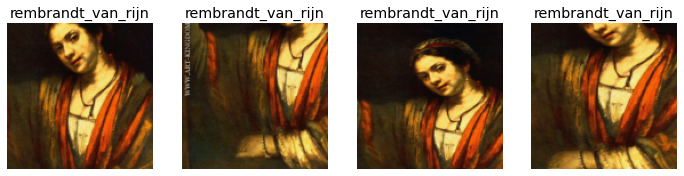

In [28]:
# even if the scaling issue should not be that of a problem with painting
# we encourage the model to generalize with a random resize crop
paintings_block_rnd = paintings_block.new(item_tfms=RandomResizedCrop(128, min_scale=.3))
loader_rnd = paintings_block_rnd.dataloaders(path)
loader_rnd.train.show_batch(max_n=4, nrows=1, unique=True)

### Data Augmentation

In [29]:
# lets see if some predefined data transformation yield good results
paintings_block_trans = paintings_block_rnd.new(item_tfms=Resize(128), batch_tfms=aug_transforms(mult=2))
loader_trans = paintings_block_trans.dataloaders(path)

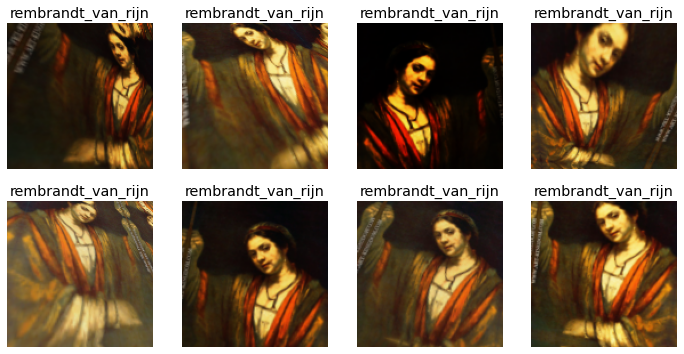

In [30]:
loader_trans.train.show_batch(max_n=8, nrows=2, unique=True)

### Train the Model

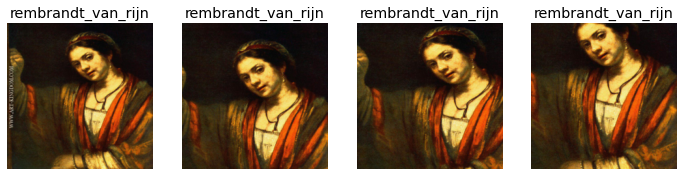

In [31]:
# we're only using the randomized crop block but with higher resolution
paintings_block_rnd = paintings_block.new(item_tfms=RandomResizedCrop(224, min_scale=.5))
loader_rnd = paintings_block_rnd.dataloaders(path)
loader_rnd.train.show_batch(max_n=4, nrows=1, unique=True)

In [32]:
# create the learner
learn = cnn_learner(loader_rnd, resnet18, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.919094,0.917289,0.281553,00:23


epoch,train_loss,valid_loss,error_rate,time
0,1.167541,0.657054,0.179612,00:20
1,0.879507,0.526489,0.165049,00:19
2,0.636609,0.483729,0.135922,00:20
3,0.474647,0.471644,0.138350,00:18


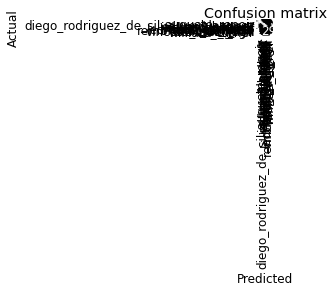

In [34]:
# lets see what our result is
interpretation = ClassificationInterpretation.from_learner(learn)
interpretation.plot_confusion_matrix()

In [35]:
# try another architecture
learn = cnn_learner(loader_rnd, resnet34, metrics=error_rate)
learn.fine_tune(4)

epoch,train_loss,valid_loss,error_rate,time
0,2.812383,0.888714,0.266990,00:20


epoch,train_loss,valid_loss,error_rate,time
0,1.081281,0.579873,0.157767,00:21
1,0.785672,0.461586,0.109223,00:21
2,0.528285,0.402039,0.111650,00:21
3,0.385234,0.386620,0.111650,00:20


The deeper resnet architecture did yield a slightly better error rate.

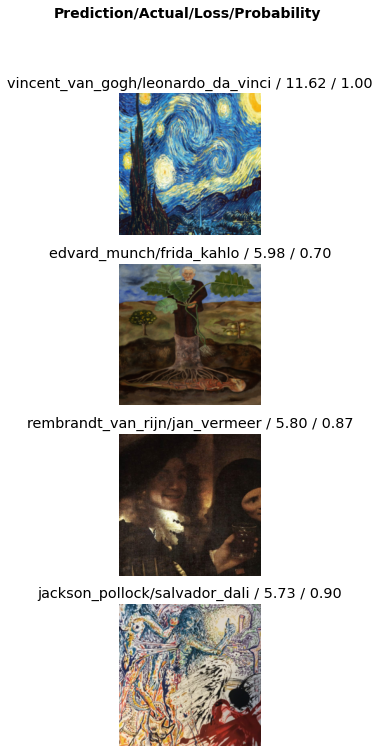

In [36]:
# lets see where our model did bad
interpretation.plot_top_losses(4, nrows=4)

There are obviously some problems with the labels. We might correct these later.

In [37]:
# show results
interpretation.print_classification_report()

                                      precision    recall  f1-score   support

                      auguste_renoir       0.94      0.94      0.94        33
diego_rodriguez_de_silva_y_velazquez       0.77      0.81      0.79        21
                        edvard_munch       0.81      0.86      0.83        35
                       edward_hopper       0.96      0.93      0.95        29
                         frida_kahlo       0.96      0.96      0.96        24
                     jackson_pollock       0.86      0.96      0.91        26
                         jan_vermeer       0.92      0.82      0.87        28
                   leonardo_da_vinci       0.93      0.79      0.86        34
                        michelangelo       0.81      0.83      0.82        41
                       pablo_picasso       0.73      0.79      0.76        24
                  rembrandt_van_rijn       0.74      0.92      0.82        25
                       salvador_dali       0.91      0.70      

### Save the Model

In [38]:
learn.export('../storage/famous_painters.pkl')

In [39]:
# check if model has been saved
path = Path('../storage')
path.ls(file_exts='.pkl')

(#1) [Path('../storage/famous_painters.pkl')]

In [41]:
# reload learner to test
reloaded_learner = load_learner(path/'famous_painters.pkl')

In [52]:
!ls ../storage/painters/frida_kahlo | head

00000000.jpg
00000001.jpg
00000002.jpg
00000003.jpg
00000004.jpg
00000005.jpg
00000006.jpg
00000007.jpg
00000008.jpg
00000009.jpg


In [56]:
# validate loaded learner
reloaded_learner.predict(path/'painters/frida_kahlo/00000006.jpg')

('frida_kahlo',
 tensor(4),
 tensor([8.0335e-05, 8.7017e-04, 3.8216e-05, 6.6783e-05, 9.9811e-01, 1.6804e-05, 2.3185e-05, 1.4741e-04, 3.2011e-05, 3.7641e-06, 4.9683e-06, 1.5832e-05, 5.7957e-04, 9.5598e-06]))

### Creating a Notebook App

In [57]:
btn_upload = widgets.FileUpload()
btn_upload

FileUpload(value={}, description='Upload')

In [60]:
img = PILImage.create(btn_upload.data[-1])

In [61]:
# creating output widget
out_pl = widgets.Output()
out_pl.clear_output()
out_pl

Output()

In [62]:
# outputting to widget
with out_pl: display(img.to_thumb(128,128))

In [64]:
# make the prediction
pred,pred_idx,probs = reloaded_learner.predict(img)
pred, pred_idx, probs

('jackson_pollock',
 tensor(5),
 tensor([6.5845e-04, 6.4516e-04, 8.4919e-04, 3.0273e-05, 1.3174e-05, 9.9702e-01, 1.0017e-06, 4.7842e-06, 3.8252e-05, 1.4551e-04, 3.9404e-05, 1.4712e-05, 2.2267e-04, 3.2030e-04]))

In [65]:
# create a label
lbl_pred = widgets.Label()
lbl_pred.value = f'Prediction: {pred}; Probability: {probs[pred_idx]:.04f}'
lbl_pred

Label(value='Prediction: jackson_pollock; Probability: 0.9970')

Note: the actual app has been moved to dedicated notebook 'artist_classifier.ipynb'